In [1]:
import pygsp as p

import numpy as np
from numpy.linalg import matrix_rank, inv, pinv
import matplotlib.pyplot as plt

import cv2

from scipy import fft

from scipy.sparse.linalg import eigs
from scipy.linalg import eig
from scipy.optimize import linprog, minimize, Bounds

In [2]:
from ripser import ripser
from persim import plot_diagrams

# First example: minimizing (only) the laplacian quadratic form 

$$
    \min_L \ \ x^T L x = \frac{1}{2}\sum_{i, j} w_{ij}(x_i - x_j)^2
$$

In [3]:
data_rs = np.random.RandomState(12845)

In [4]:
# função que define os dados
def start_points(n = 100, r = 1, eps = 0.2, rs = data_rs):
    ps = []
    thetas = []
    n = 100
    for i in range(n):
        theta = rs.uniform(0, 2 * np.pi)
        eps = rs.uniform(-0.2, 0.2)
        x, y  = (r + eps) * np.cos(theta), (r + eps) * np.sin(theta)
        thetas += [theta]
        ps += [[x,y]]
    return thetas, np.array([np.array(q) for q in ps])

In [5]:
def setup_signal(x):
    
    n = len(x)
    coefs = []
    
    for i in range(n):
        for j in range(i, n):
            
            if i == j:
                continue
            
            coefs += [(x[i] - x[j]) ** 2]
    
    return np.array(coefs)

def setup_A_eq(x):
    
    n = len(x)
    indexes = [i for i in range(n ** 2)]

    for k in range(n ** 2):
        #por algum motivo estava pulando os ifs, ai separei
        if (k % n) == (k // n):
            
            indexes.remove(k)
            continue
    
        if (k % n) < (k // n):
            
            indexes.remove(k)
            continue
    
    A_eq = np.ones((1, len(indexes)))
    
    return A_eq

def get_bounds(L):
    
    return len(L) * [(0, None)]

def laplacian_quadratic_form(L, x):
    
    n = len(x)
    indexes = [i for i in range(n ** 2)]
    
    for k in range(n ** 2):
        
        if (k % n) == (k // n):
            
            indexes.remove(k)
        
        if (k % n) < (k // n):
            
            indexes.remove(k)

    return 1/2 * sum([abs(L[k]) * (x[k % n] - x[k // n]) ** 2 for k in indexes])

In [6]:
def make_graph(n, ws):
    
    new_ws = np.round(ws, 10)
    W = np.zeros((n, n))
    W[np.triu_indices(n, 1)] = new_ws
    for i in range(1, n):
        for j in range(i):
            W[i, j] = W[j, i]
    return p.graphs.Graph(W)

In [7]:
thetas, data = start_points()
signal1 = np.array(thetas)
signal2 = np.cos(thetas)
signal3 = np.sin(thetas)

In [13]:
A_eq = setup_A_eq(signal1)

l1 = lambda L: laplacian_quadratic_form(L, signal1)
l2 = lambda L: laplacian_quadratic_form(L, signal2)
l3 = lambda L: laplacian_quadratic_form(L, signal3)

N = 100

In [17]:
%%time 
#demora bastante
#valor aleatorio pode causar um warning, mas o resultado ainda funciona
res1 = linprog(setup_signal(signal1),
              A_eq = A_eq,
              b_eq = [N], #esse valor junto com as restrições (0, 1)
              bounds = (0, 1), #para os pesos força o grafo a ter mais arestas
              options = {'tol': 1e-6, 'sym_pos': False},) #evita dois warnings

res2 = linprog(setup_signal(signal2),
              A_eq = A_eq,
              b_eq = [N], 
              bounds = (0, 1), 
              options = {'tol': 1e-6, 'sym_pos': False},)

res3 = linprog(setup_signal(signal3),
              A_eq = A_eq,
              b_eq = [N], 
              bounds = (0, 1), 
              options = {'tol': 1e-6, 'sym_pos': False},)

CPU times: user 29min 11s, sys: 1min 47s, total: 30min 58s
Wall time: 5min 39s


In [18]:
G1 = make_graph(len(signal1), res1.x)
G1.set_coordinates(data)

G2 = make_graph(len(signal2), res2.x)
G2.set_coordinates(data)

G3 = make_graph(len(signal3), res3.x)
G3.set_coordinates(data)

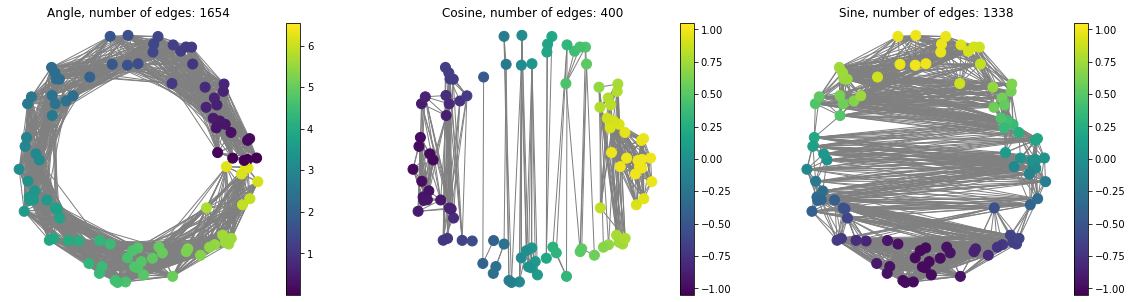

In [19]:
fig, ax = plt.subplots(1, 3, figsize = (20, 5))

G1.plot_signal(signal1, ax = ax[0])
G2.plot_signal(signal2, ax = ax[1])
G3.plot_signal(signal3, ax = ax[2])

ax[0].set_title('Angle, number of edges: ' + str(G1.Ne))
ax[1].set_title('Cosine, number of edges: ' + str(G2.Ne))
ax[2].set_title('Sine, number of edges: ' + str(G3.Ne))

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

plt.savefig('imgs/test4/borsuk-ulam')
plt.show()

# Second example:

$$
    \min_{y, L} \ \ \|x - y \|^2_2 + \alpha y^T L y, \text{where } L = V^{-1} \Lambda V \text{ and } y = Vc
$$